<a href="https://colab.research.google.com/github/rafaelsouza13/matpython/blob/master/Series_de_Fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aproximação de funções periódicas com Séries de Fourier

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

Vamos aproximar com uma Série de Fourier a extensão periódica de período $2\pi$ da função $f: \mathbb{R} \to \mathbb{R}$ dada por
$f(t) =  \begin{cases} 
      0 & -\pi \leq t < 0 \\
      t & 0 < t \leq \pi
   \end{cases}
$

Primeiro, definimos a função `f(t)` para calcular os valores de $f(t)$. Observe que a função é indefinida em $t=0$.

In [2]:
def f(t):
    if t >= -np.pi and t < 0:
        return 0
    elif t > 0 and t <= np.pi:
        return t

Vamos rapidamente visualizar essa função, gerando 100 pontos entre $-\pi$ e $\pi$ e aplicando a função nesses pontos. Usamos `X` para armazenar os pontos gerados no domínio da função e `Y` para armazenar o resultado da função em cada um dos pontos de `X`.

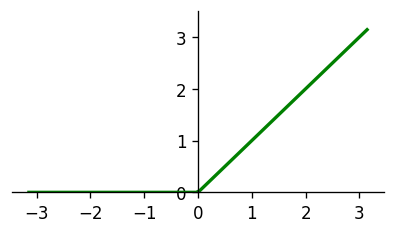

In [3]:
X = np.linspace(-np.pi, np.pi, 100)
Y = np.vectorize(f, otypes=[np.float])(X)

fig, ax = plt.subplots(figsize=(4, 2), dpi=120,)
ax.set_ylim(0, 3.5)
ax.plot(X, Y, linestyle='-', color='green', linewidth=2)

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

Definimos agora as funções `an(n)`, `bn(n)` e `a_zero()` para computar os valores de $a_{n}$, $b_{n}$ e $a_{0}$. Observe que essas funções utilizam a função `f` e têm definições genéricas, i.e. essas funções valem para qualquer $f$ periódica com período $2\pi$ variando de $-\pi$ a $\pi$.

A única ressalva é que precisamos passar os pontos de dificuldade de integração no parâmetro `points` da função `integrade.quad`. Esses pontos dependem da função `f` em questão.

In [4]:
def an(n): # nossa função depende de n
    def anf(t): # definimos aqui a função que será integrada
        return f(t) * np.cos(n * t)
    return integrate.quad(anf, -np.pi, np.pi, points=[0])[0] / np.pi #integramos a função de -pi a pi e dividimos por pi

In [5]:
def bn(n):
    def bnf(t):
        return f(t) * np.sin(n * t)
    return integrate.quad(bnf, -np.pi, np.pi, points=[0])[0] / np.pi

In [6]:
def a_zero():
      return integrate.quad(f, -np.pi, np.pi, points=[0])[0] / np.pi

Agora vamos definir a função que conecta tudo que foi definido anteriormente. A função `ft(t, n)` computa os termos da Série de Fourier correspondente a `n` no ponto `t`.

Para $n=0$ , retornamos simplesmente $\frac{a_{0}}{2}$.

Para $n>0$, retornamos a  $a_{n}$ e $b_{n}$.

In [7]:
def ft(t, n):
    if n == 0:
        return a_zero()/2
    else:
        return an(n) * np.cos(n * t) + bn(n) * np.sin(n * t)

Já temos tudo que precisamos para gerar as aproximações de $f$, mas antes disso, vamos definir a função `f_ext(t)`que computa a extensão periódica de $f$. Vamos usar essa função para comparar as nossas aproximações com a função verdadeira.

Vamos usar a função módulo, ou o resto da divisão inteira, para gerar essa extensão. Observe no gráfico da função $f$ acima que, se trasladarmos a função à direita em $\pi$, teremos uma função com um comportamamento em $ \mathopen[ 0, \pi \mathopen[$ e outro comportamento em $ \mathopen[ \pi, 2 \pi \mathopen[$. Se extendermos essa função em $2\pi$, teremos uma regra simples para determinar o comportamento em qualquer ponto $t$: basta tomar o resto da divisão inteira $t \mod 2\pi$ e verificar se esse valor é maior ou menor que $\pi$.

In [8]:
def f_ext(t):
    t = t - np.pi
    if np.mod(t, 2 * np.pi) < np.pi:
        return 0
    elif (2 * np.pi) - np.mod(t, 2 * np.pi) < 0.2: # aqui retornamos np.nan para indicar uma descontinuidade
        return np.nan
    else:
        return np.mod(t, np.pi)

Vamos visualizar a extensão periódica da função. Aqui, estamos visualizando cinco períodos.

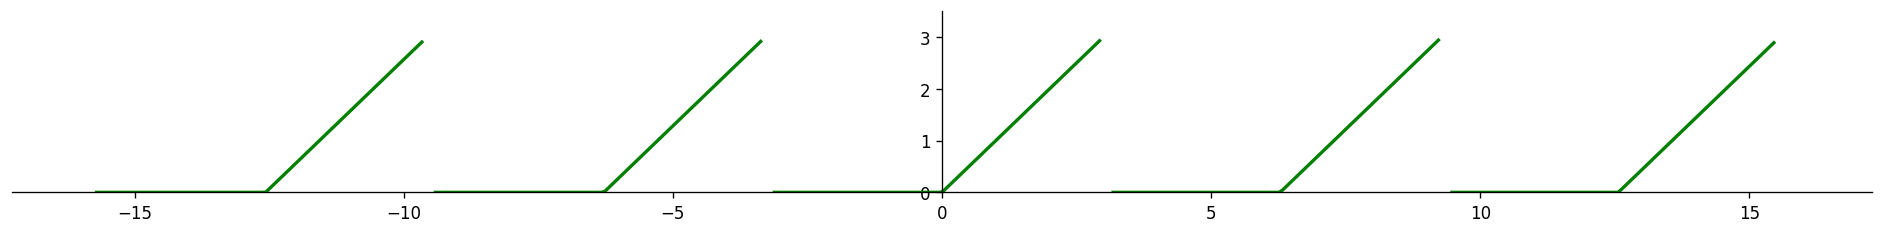

In [9]:
periodos = 5
pontos_por_periodo = 100
pontos = periodos * pontos_por_periodo

X = np.linspace(periodos * -np.pi, periodos * np.pi, pontos)
Y = np.vectorize(f_ext, otypes=[np.float])(X)

fig, ax = plt.subplots(figsize=(periodos * 4, 2), dpi=120,)
ax.set_ylim(0, 3.5)
ax.plot(X, Y, linestyle='-', color='green', linewidth=2)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

Agora vamos gerar a aproximação pela Série de Fourier. Vamos usar uma matriz $C_{N+1 \times P}$, onde $N$ é o maior valor de $n$ para o qual computaremos a aproximação e $P$ é o número de pontos que serão computados. No código, usamos `n` para representar $N$, `pontos` para $P$, e `C` para $C$.

In [10]:
n = 20
C = np.zeros((n+1, pontos))

Aqui, só computamos a função `ft` para cada ponto $t$ em `X` e cada valor $n$ de $0$ a $N$.

In [11]:
for i in range(n+1):
    for j in range(pontos):
        C[i, j] = ft(X[j], i)

Já temos tudo que precisamos para gerar a aproximação. Com a matrix $C$, só precisamos somar as linhas de $0$ a qualquer valor de $n \leq N+1$ para gerar a aproximação da função em cada ponto $t$. Relembrando, temos $N+1$ linhas na matriz $C$ porque estamos contando de $0$ a $N$, inclusive.

Abaixo, geramos primeiro uma animação e depois uma sequência de figuras comparando a extensão periódica verdadeira (em verde) com a aproximação em cada valor de $n$ (em azul).

<Figure size 432x288 with 0 Axes>

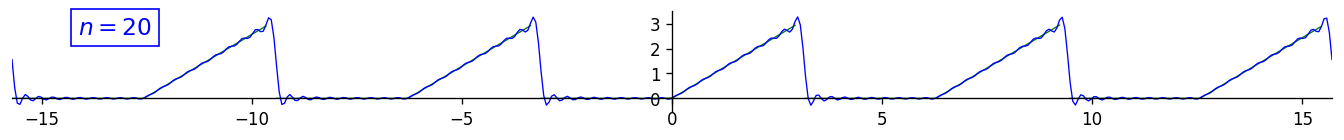

In [21]:
escala = 0.55 # ajuste da escala para facilitar a visualiazação inline
plt.gcf()
fig = plt.figure(figsize=(periodos * 4 * escala, 2 * escala), dpi=120,)
fig.subplots_adjust(left=0, right=1)
ax = plt.axes(xlim=(periodos * -np.pi, periodos * np.pi), ylim=(-0.5, 3.5))

ax.set_yticks([0,1,2,3])
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

ax.plot(X, Y, linestyle='-', color='green', linewidth=0.8)
line, = ax.plot([], [], linestyle='-', color='blue', linewidth=0.8)
props = dict(boxstyle='square', facecolor='white', edgecolor='blue', alpha=1)
text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='blue')

def init():
    line.set_data([], [])
    return line,
def animate(i):
    line.set_data(X, np.sum(C[0:i, :], axis=0))
    text.set_text(f'$n=${i}')
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n+1, blit=True)
anim.save('fourier.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

In [23]:
HTML(anim.to_jshtml())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


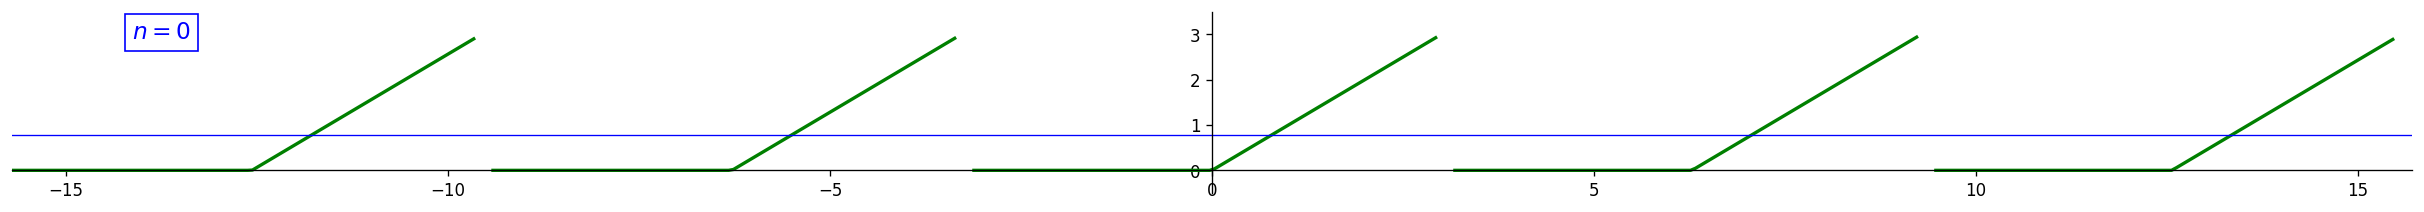

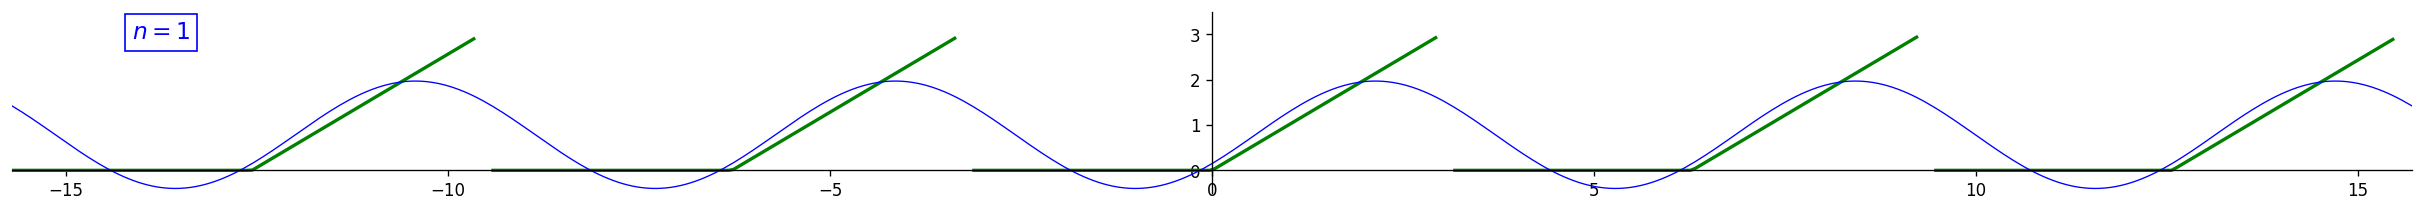

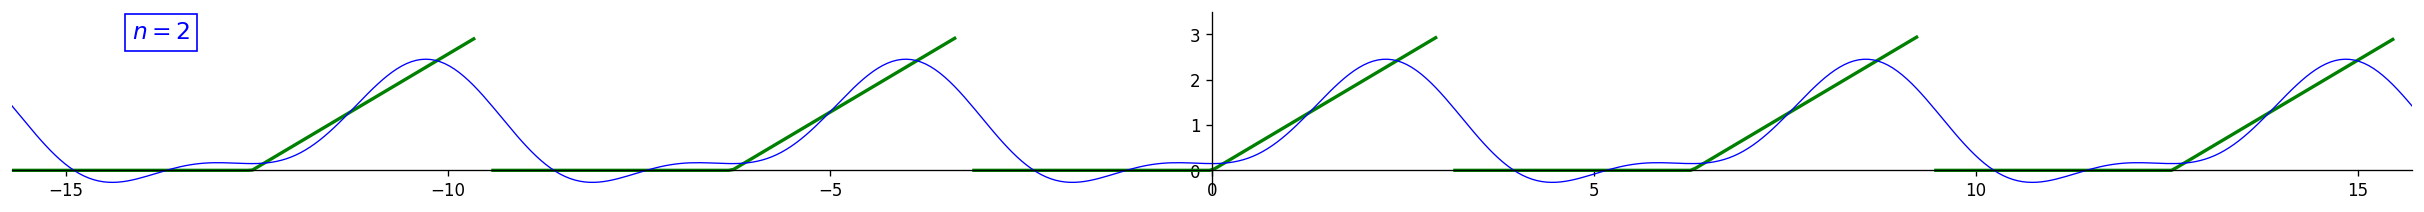

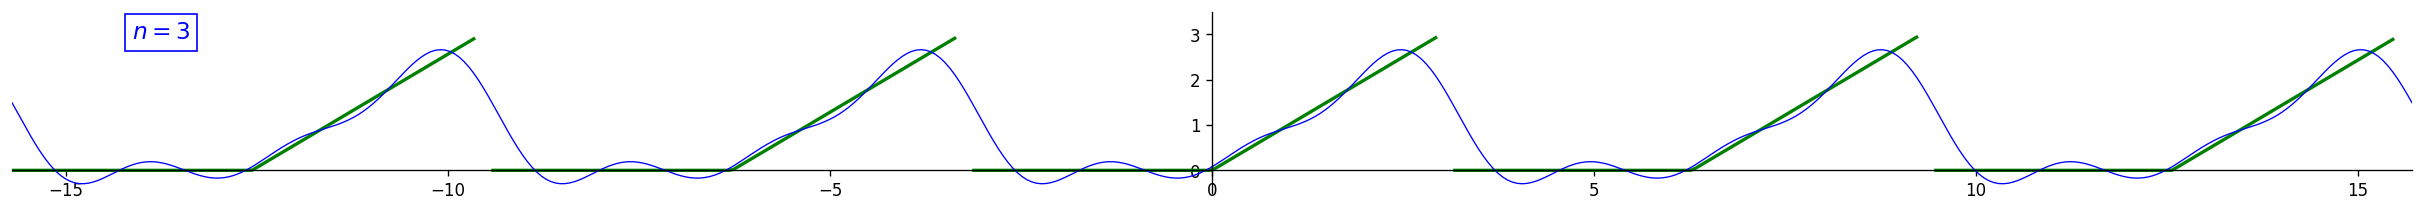

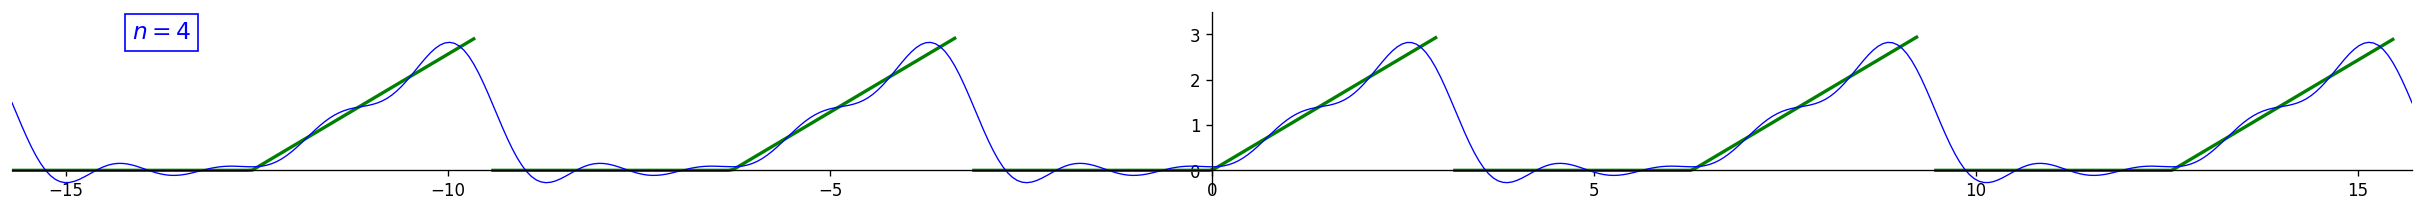

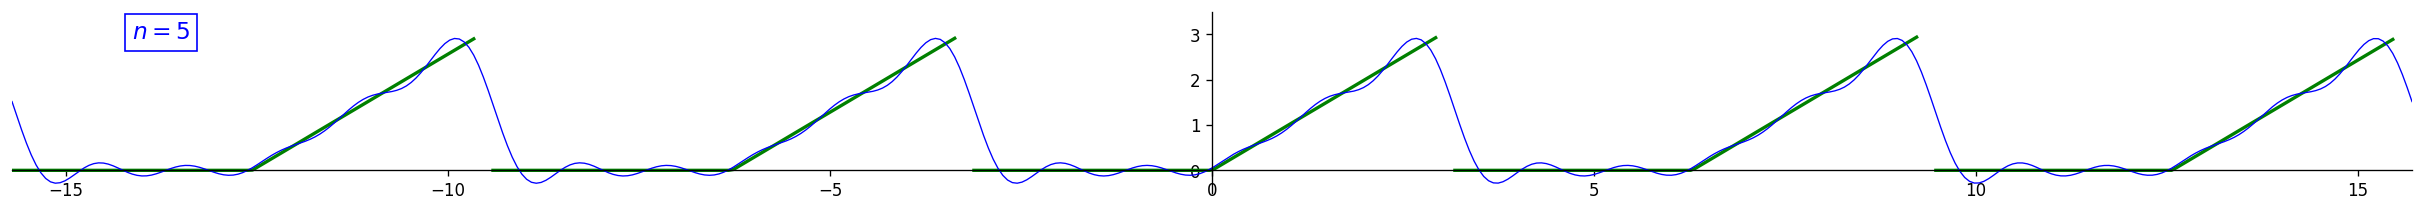

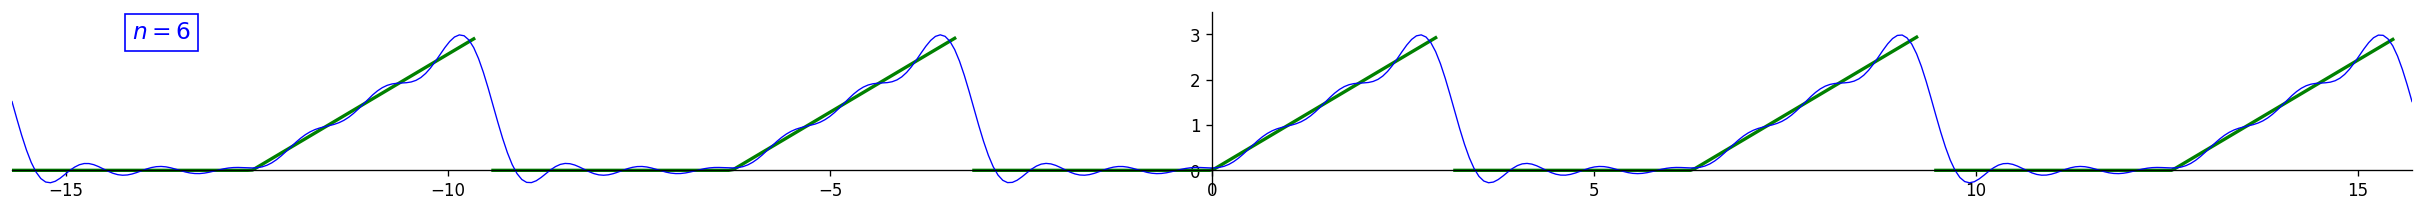

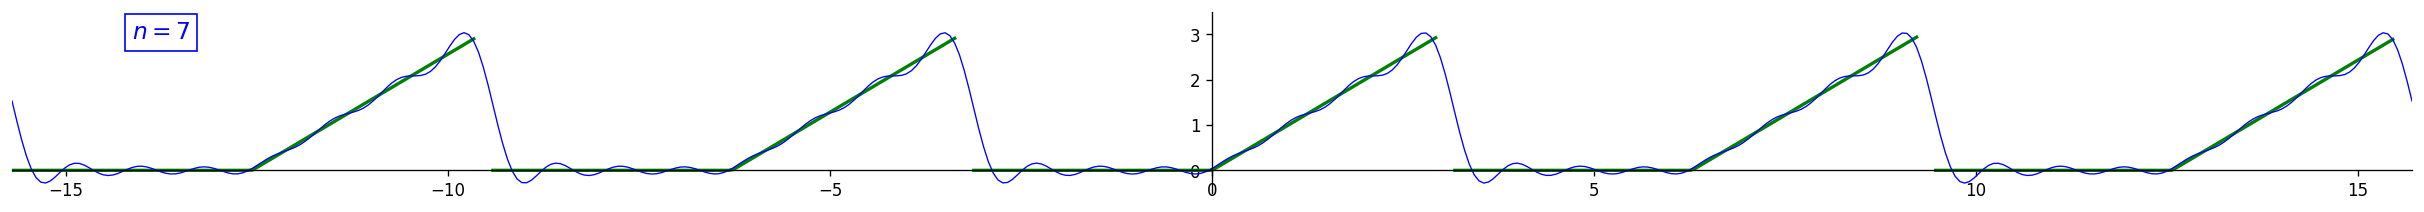

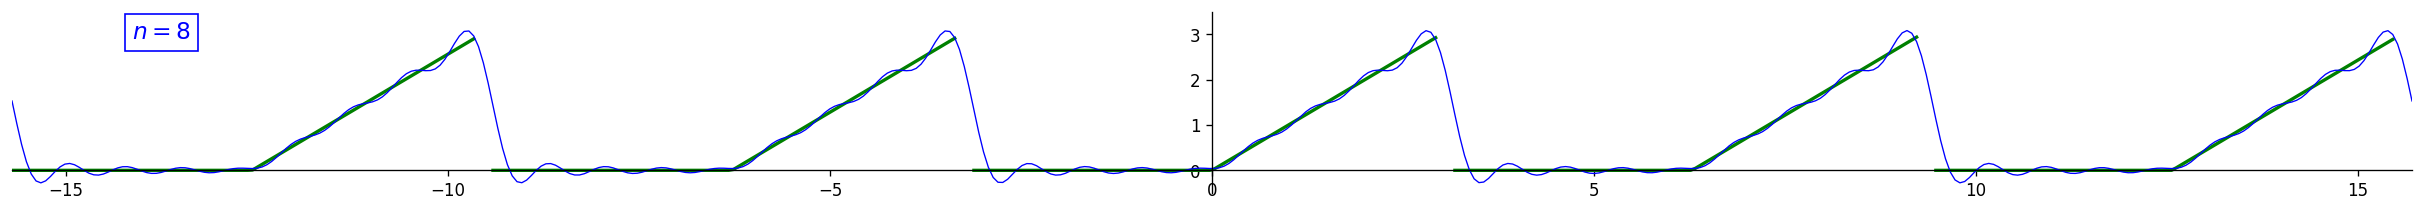

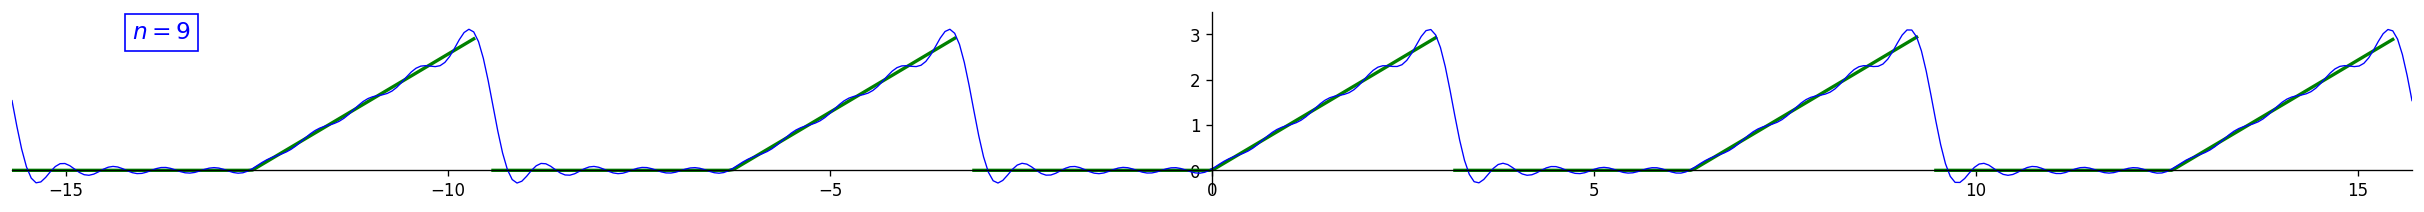

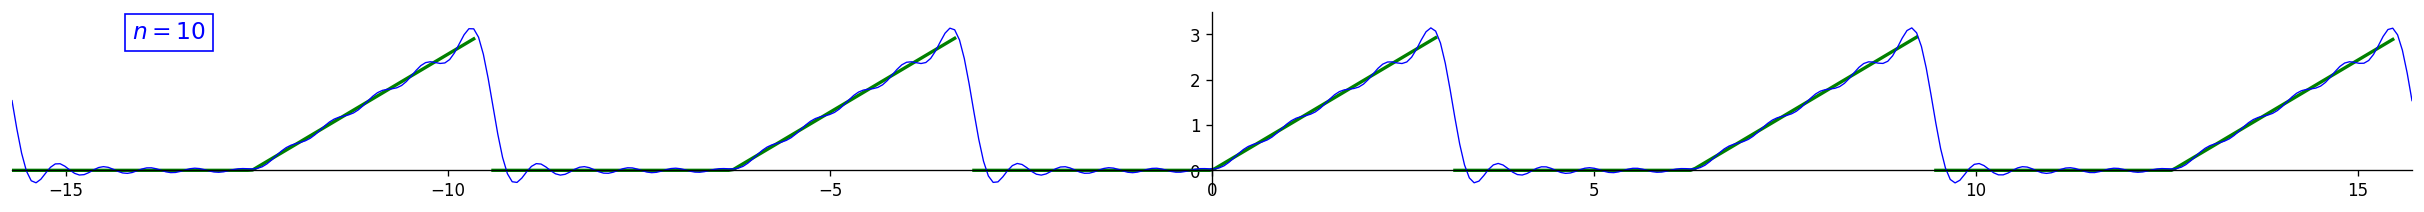

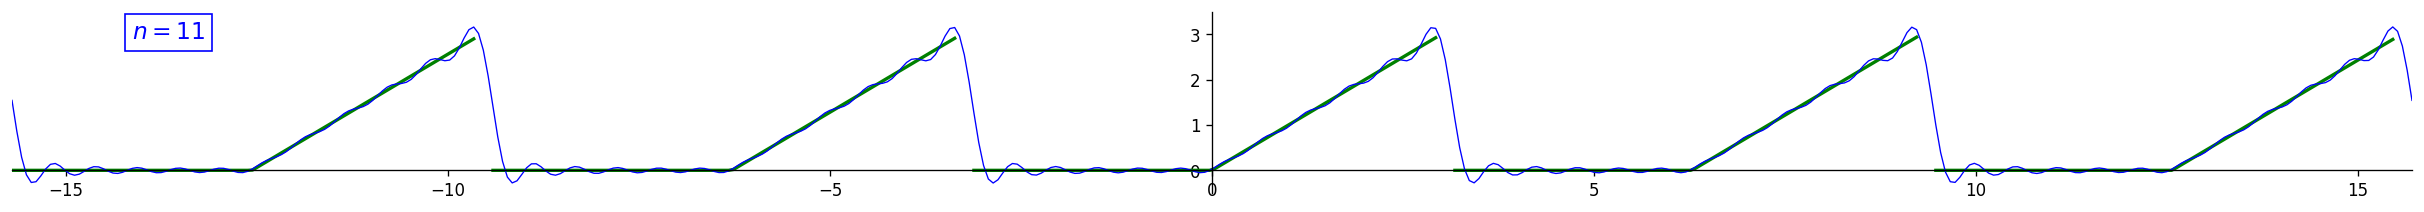

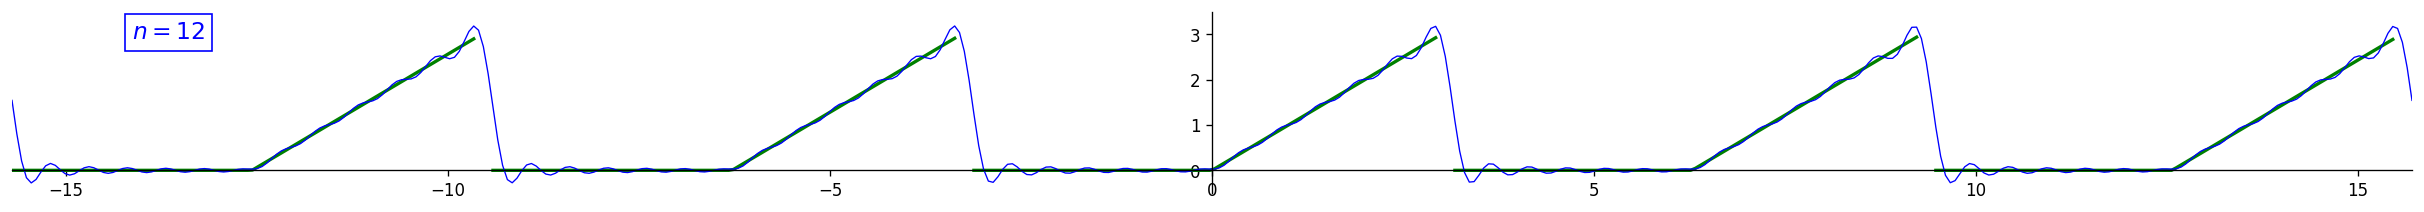

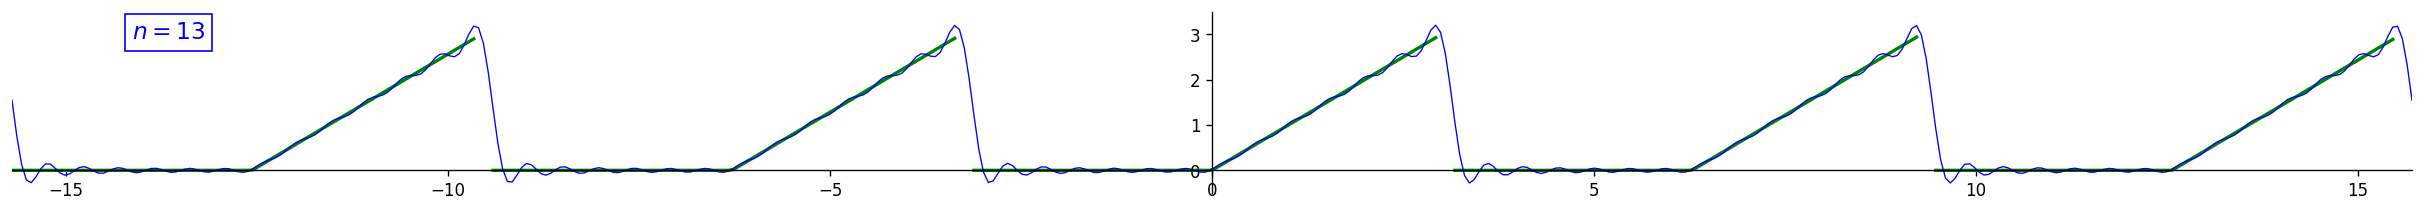

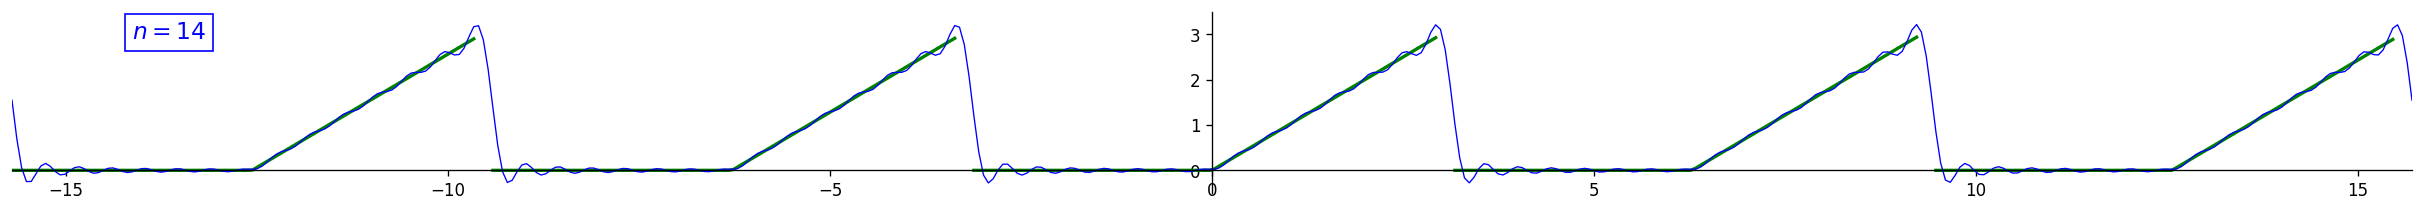

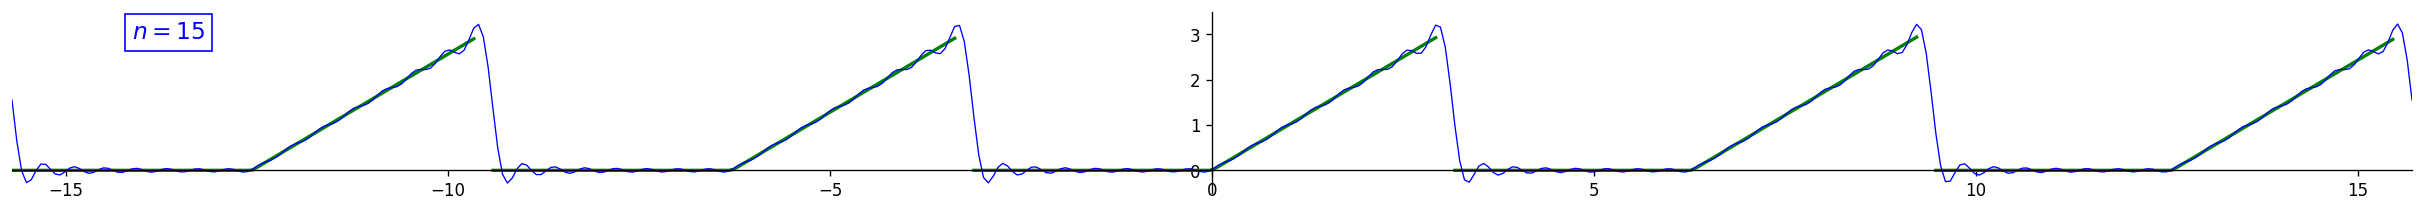

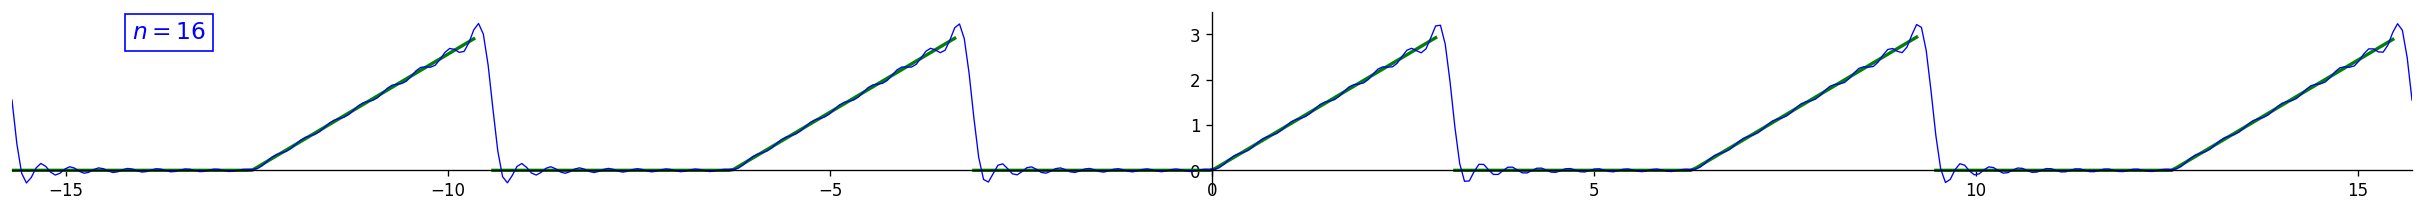

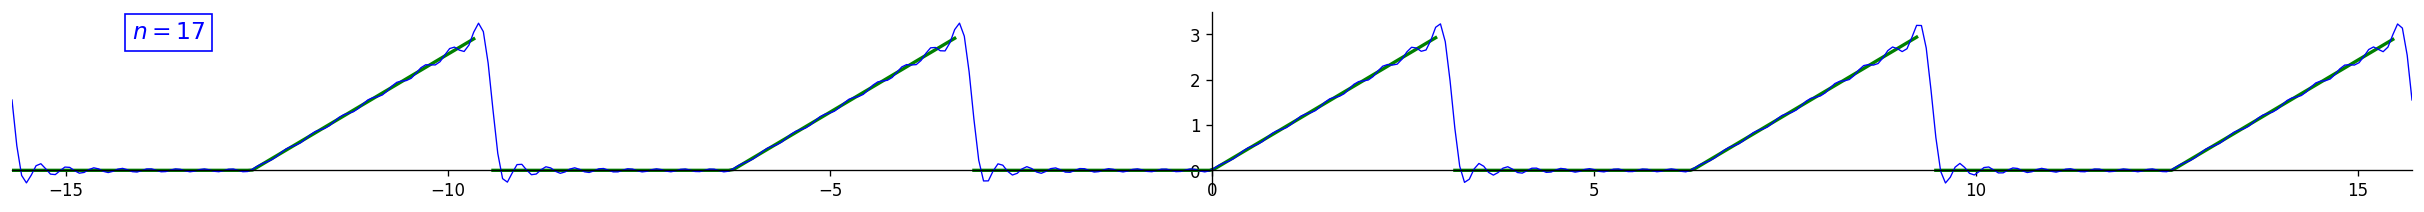

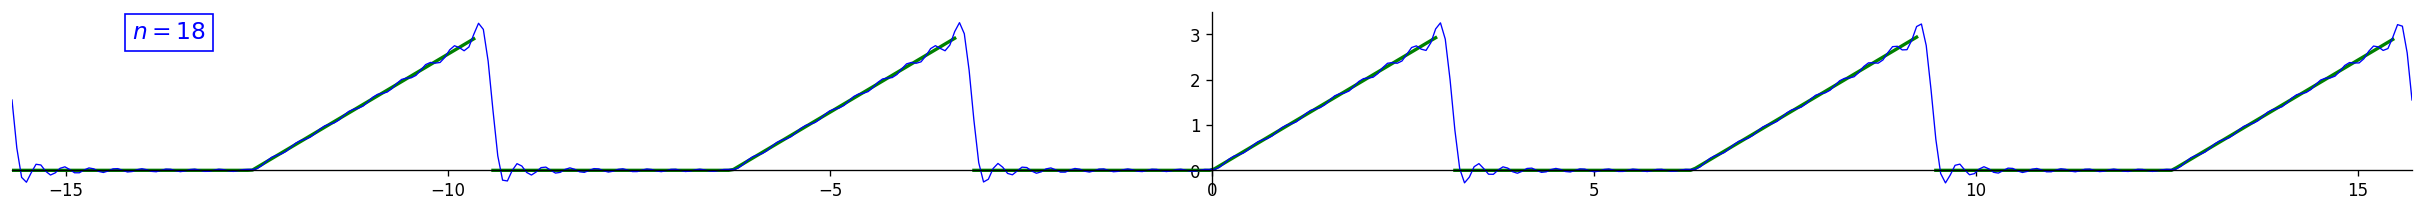

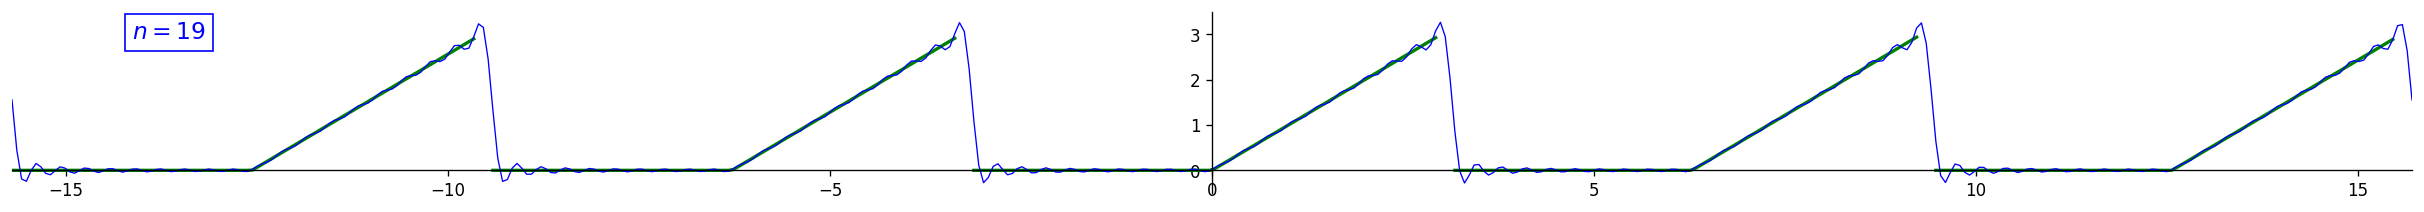

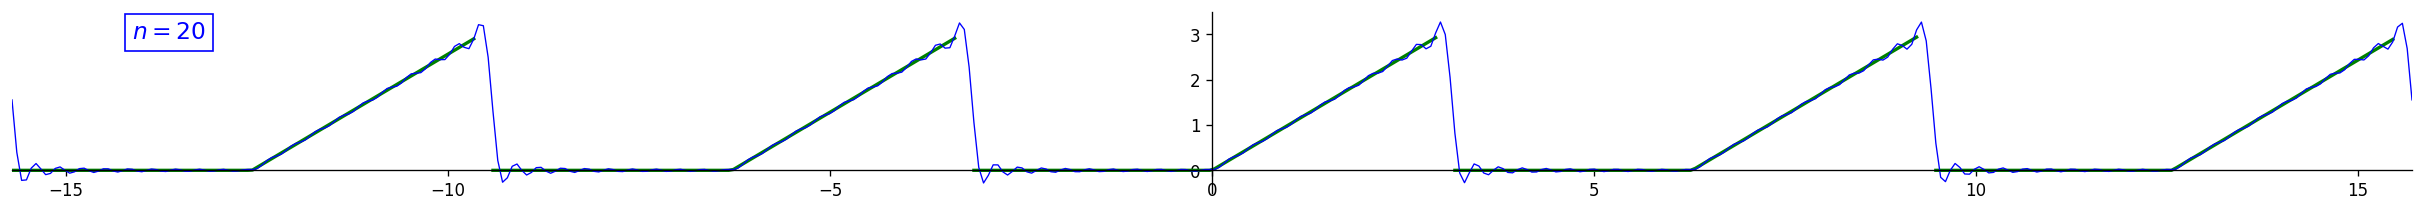

In [14]:
for n_atual in range(n+1):
    fig, ax = plt.subplots(figsize=(periodos * 4, 2), dpi=120,)
    fig.subplots_adjust(left=0, right=1)
    ax.set_ylim(-0.5, 3.5)
    ax.set_xlim(periodos * -np.pi, periodos * np.pi)
    ax.plot(X, Y, linestyle='-', color='green', linewidth=2)
    ax.plot(X, np.sum(C[0:n_atual+1, :], axis=0), linestyle='-', color='blue', linewidth=0.8)
    props = dict(boxstyle='square', facecolor='white', edgecolor='blue', alpha=1)
    text = ax.text(0.05, 0.95, f'$n=${n_atual}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='blue')
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    fig.savefig(f'fourier_n{n_atual}.png')